In [1]:
import os
os.chdir("../../../../")

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = str(3)

In [3]:
import jax
import jax.numpy as jnp
import numpy as np
import flax.linen as nn
import optax
import pandas as pd
from functools import partial
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from utilities.fits import fit
from datasets.dataset_loader import dataset_load
from utilities import plot, gmm, errors, predict, preprocess
from utilities.recalibration_conformal import *
from models import seq2point
import scipy.stats as st
from mapie.metrics import regression_coverage_score
from sklearn.isotonic import IsotonicRegression
from tueplots import bundles
os.environ["XLA_FLAGS"] = "--xla_gpu_deterministic_reductions --xla_gpu_autotune_level=2"
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

# Model Training

In [4]:
train = {1: {
    'start_time': "2011-04-21",
    'end_time': "2011-05-21"
},
    3: {
    'start_time': "2011-04-19",
    'end_time': "2011-05-22"
},
    2: {
    'start_time': "2011-04-21",
    'end_time': "2011-05-21"
},
    5: {
    'start_time': "2011-04-22",
    'end_time': "2011-06-01"
}}
test = {6: {
    'start_time': "2011-05-25",
    'end_time': "2011-06-13"
}}
appliances = ["Refrigerator"]

In [5]:
datas = dataset_load(appliances, train, test, 99, split_factor=0.25)
x_train, y_train = datas[0], datas[1]
x_cal, y_cal = datas[2], datas[3]
x_test, y_test = datas[4], datas[5]
x_test_timestamp = datas[6]
scaler_x, scaler_y = datas[7], datas[8]

In [6]:
training_predictions_df = pd.DataFrame()
testing_predictions_df = pd.DataFrame()
calibration_predictions_df = pd.DataFrame()
training_predictions_df["Ground Truth"] = scaler_y.inverse_transform(y_train)[
    :, 0]
calibration_predictions_df['Ground Truth'] = scaler_y.inverse_transform(y_cal)[
    :, 0]
testing_predictions_df["Timestamp"] = x_test_timestamp
testing_predictions_df["Ground Truth"] = y_test

In [7]:
model = seq2point.seq2point()

In [8]:
%%capture cap --no-stderr
%%time
params =  model.init(jax.random.PRNGKey(0), x_train, True)
params, losses = fit(model, params, x_train, y_train, False, batch_size=32, learning_rate=0.001, epochs=50)

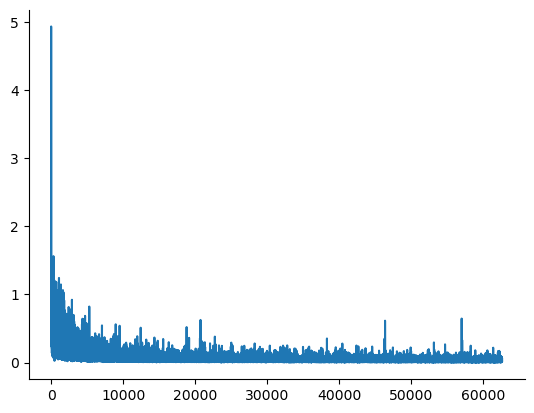

In [9]:
plt.plot(losses)
sns.despine()

In [10]:
mlp_training_time = cap.stdout.split('\n')[1]
mlp_training_time

'Wall time: 1min 22s'

In [11]:
def de_train(x, y, i, model):
    param = model.init(jax.random.PRNGKey(i), x_train, True)
    param, losses = fit(model, param, x, y, False, batch_size=32,
                        learning_rate=0.001, epochs=50)
    return param, losses


de_train = jax.tree_util.Partial(de_train, model=model)


def predict(x, param, model):
    yhat = model.apply(param, x, True)
    return yhat


test_ = jax.tree_util.Partial(predict, model=model)

In [12]:
%%capture cap
%%time
params_list, losses_list = jax.jit(jax.vmap(de_train, in_axes=(None, None, 0)))(x_train, y_train, jnp.arange(10))

In [13]:
de_training_time = cap.stdout.split('\n')[1]
de_training_time

'Wall time: 5min 44s'

# Before Calibration

##### Results on Calibration Set

In [14]:
%%capture cap
%%time
y_stacks = jax.jit(jax.vmap(test_, in_axes=(None, 0)))(x_cal, params_list)

In [15]:
mlp_calibration_time = cap.stdout.split('\n')[1]
mlp_calibration_time

'Wall time: 2.85 s'

In [16]:
de_cal_mean = y_stacks.mean(axis=0)
de_cal_sigma = y_stacks.std(axis=0)

In [17]:
de_cal_mean = scaler_y.inverse_transform(de_cal_mean)
de_cal_sigma = (scaler_y.scale_*de_cal_sigma)
y_true_cal = scaler_y.inverse_transform(y_cal)

In [18]:
print(f"RMSE : {errors.rmse(y_true_cal, de_cal_mean):.4f}",
      f"MAE  : {errors.mae(y_true_cal, de_cal_mean):.4f}",
      f"NLL  : {errors.NLL(de_cal_mean, de_cal_sigma, y_true_cal):.4f}")

RMSE : 14.9257 MAE  : 6.2771 NLL  : 3.0589


In [19]:
calibration_predictions_df['DE_mean'] = de_cal_mean
calibration_predictions_df['DE_sigma'] = de_cal_sigma

##### Results on Training Set

In [20]:
y_stacks_train = jax.jit(
    jax.vmap(test_, in_axes=(None, 0)))(x_train, params_list)
de_train_mean = y_stacks_train.mean(axis=0)
de_train_sigma = y_stacks_train.std(axis=0)

In [21]:
de_train_mean = scaler_y.inverse_transform(de_train_mean)
de_train_sigma = (scaler_y.scale_*de_train_sigma)
y_train_scaled = scaler_y.inverse_transform(y_train)

In [22]:
print(f"RMSE : {errors.rmse(y_train_scaled, de_train_mean):.4f}",
      f"MAE  : {errors.mae(y_train_scaled, de_train_mean):.4f}",
      f"NLL  : {errors.NLL(de_train_mean, de_train_sigma, y_train_scaled):.4f}")

RMSE : 5.3208 MAE  : 2.7897 NLL  : 2.5888


In [23]:
training_predictions_df['DE_mean'] = de_train_mean
training_predictions_df['DE_sigma'] = de_train_sigma

##### Results on Test Set

In [24]:
%%capture cap
%%time
y_stacks_test = jax.jit(
    jax.vmap(test_, in_axes=(None, 0)))(x_test, params_list)

In [25]:
de_test_mean = y_stacks_test.mean(axis=0)
de_test_sigma = y_stacks_test.std(axis=0)

In [26]:
de_test_mean = scaler_y.inverse_transform(de_test_mean)
de_test_sigma = (scaler_y.scale_*de_test_sigma)

In [27]:
print(f"RMSE : {errors.rmse(y_test, de_test_mean):.4f}", f"MAE  : {errors.mae(y_test, de_test_mean):.4f}",
      f"NLL  : {errors.NLL(de_test_mean, de_test_sigma, y_test):.4f}")

RMSE : 41.5577 MAE  : 24.5851 NLL  : 7.5449


In [28]:
testing_predictions_df['de_Mean'] = de_test_mean
testing_predictions_df['de_Sigma'] = de_test_sigma

In [29]:
mlp_testing_time = cap.stdout.split('\n')[1]
mlp_testing_time

'Wall time: 3.4 s'

In [30]:
training_predictions_df.to_csv(
    "notebooks/fridge/s2p/mlp/preds/training_predictions_homo_de.csv", index=False)
calibration_predictions_df.to_csv(
    "notebooks/fridge/s2p/mlp/preds/calibration_predictions_homo_de.csv", index=False)
testing_predictions_df.to_csv(
    "notebooks/fridge/s2p/mlp/preds/testing_predictions_homo_de.csv", index=False)

# After Calibration

In [31]:
recalibration_df = pd.DataFrame()

### Isotonic Regression

In [32]:
def ace(ideal, predicted):
    """
    dataframe : pandas dataframe with Ideal and Counts as column for regression calibration
    It can be directly used as 2nd output from calibration_regression in plot.py 
    """
    def rmse_loss(y, yhat):
        return jnp.abs(y-yhat)
    return jnp.mean(jax.vmap(rmse_loss, in_axes=(0, 0))(ideal, predicted))

In [33]:
%%capture cap
%%time
series_train = find_p_hat(y_train_scaled, de_train_mean, de_train_sigma)
series_test = find_p_hat(y_test, de_test_mean, de_test_sigma)
series_cal = find_p_hat(y_true_cal, de_cal_mean, de_cal_sigma)

In [34]:
isotonic_1 = cap.stdout.split('\n')[1]
isotonic_1

'Wall time: 1.15 s'

In [35]:
%%capture cap
%%time
calibrator = IsotonicRegression(out_of_bounds='clip')
calibrator.fit(series_cal.values, series_cal.index)

In [36]:
isotonic_2 = cap.stdout.split('\n')[1]
isotonic_2

'Wall time: 2.27 ms'

In [37]:
%%capture cap
%%time
p = series_cal.index
new_p = calibrator.predict(series_cal.index)

In [38]:
isotonic_3 = cap.stdout.split('\n')[1]
isotonic_3

'Wall time: 206 us'

In [39]:
%%capture cap
%%time
new_p_hat_train = find_new_p_hat(
    y_train_scaled, new_p, de_train_mean, de_train_sigma)
new_p_hat_cal = find_new_p_hat(y_true_cal, new_p, de_cal_mean, de_cal_sigma)
new_p_hat_test = find_new_p_hat(y_test, new_p, de_test_mean, de_test_sigma)

In [40]:
isotonic_4 = cap.stdout.split('\n')[1]
isotonic_4

'Wall time: 257 ms'

In [41]:
recalibration_df["p"] = p
recalibration_df["phat_de"] = series_test.values
recalibration_df["new_p_de"] = new_p
recalibration_df["new_phat_de"] = new_p_hat_test

In [42]:
recalibration_df.to_csv(
    "notebooks/fridge/s2p/mlp/ic/recalibration_df_de.csv", index=False)

In [43]:
isotonic_4[11:]

'257 ms'

In [44]:
train_time = int(mlp_training_time[11:12])*60 + int(mlp_training_time[16:-1]) + int(
    de_training_time[11:12])*60 + int(de_training_time[16:-1])
calibration_time = float(mlp_calibration_time[11:15])
isotonic_time_final = float(
    isotonic_1[11:15]) + float(isotonic_2[11:15])/1000
+ float(isotonic_3[11:14])/1000000 + float(isotonic_4[11:15])/1000

0.257206

In [45]:
total_time = train_time + calibration_time + isotonic_time_final
total_time

430.00227

In [46]:
with open('notebooks/fridge/s2p/mlp/time_homo_de.txt', 'w') as file:
    file.writelines([f"MLP training :{mlp_training_time} ", f" MLP Calibration: {mlp_calibration_time}\n"
                     f"Isotonic Time: {isotonic_time_final} ", f"Total time: {total_time}s"])

In [47]:
add = []
extra = [train_time, calibration_time, isotonic_time_final, total_time]
add.append(extra)
add

[[426, 2.85, 1.15227, 430.00227]]

In [48]:
time = pd.DataFrame(add)

In [49]:
time.to_csv('notebooks/fridge/s2p/mlp/homo_de.csv',
            mode='a', index=False)

In [50]:
bundles.icml2022()

{'text.usetex': True,
 'font.family': 'serif',
 'text.latex.preamble': '\\usepackage{times} ',
 'figure.figsize': (3.25, 2.0086104634371584),
 'figure.constrained_layout.use': True,
 'figure.autolayout': False,
 'savefig.bbox': 'tight',
 'savefig.pad_inches': 0.015,
 'font.size': 8,
 'axes.labelsize': 8,
 'legend.fontsize': 6,
 'xtick.labelsize': 6,
 'ytick.labelsize': 6,
 'axes.titlesize': 8}

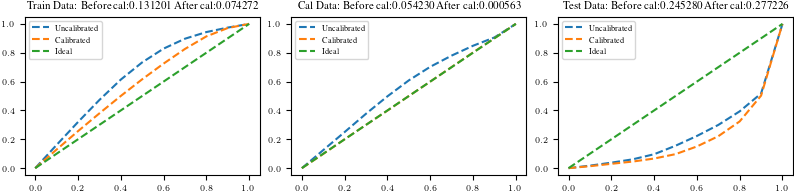

In [51]:
plt.rcParams.update(bundles.icml2022())
plt.rcParams.update({'figure.figsize': (8, 2)})
plt.subplot(1, 3, 1)
plt.plot(p, series_train.values, label='Uncalibrated', linestyle='--')
plt.plot(p, new_p_hat_train, label='Calibrated', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f"Train Data: Before cal:{ace(p.values,series_train.values):2f} After cal:{ace(p.values,new_p_hat_train):2f}")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(p, series_cal.values, label='Uncalibrated', linestyle='--')
plt.plot(p, new_p_hat_cal, label='Calibrated', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f"Cal Data: Before cal:{ace(p.values,series_cal.values):2f} After cal:{ace(p.values,new_p_hat_cal):2f}")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(p, series_test.values, label='Uncalibrated', linestyle='--')
plt.plot(p, new_p_hat_test, label='Calibrated', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f"Test Data: Before cal:{ace(p.values,series_test.values):2f} After cal:{ace(p.values,new_p_hat_test):2f}")
plt.legend()
plt.savefig(
    f'/home/haikoo.khandor/haikoo/conformal/con_figures/{appliances[0]}_S2P_Homo_DE.pdf')